# Some thoughts on linear Regressions

## Outline
* Linear regression:
    * Least squares
    * Correlation
    * Goodness of fit
* Python implementation of linear regression
* Significance and uncertainties
* Linear regression on Tempelhof temperature
* Weighted linear regression

## Additional Reading
- Chapters 7, 8, 9, 10, 11, and 12 (_they are very short chapters!_) in "Think Stats" by Allen B. Downey, available open-source [here](https://greenteapress.com/wp/think-stats-2e/)
- Derivation of least squares regression from James Kirchner [here](http://seismo.berkeley.edu/~kirchner/eps_120/Toolkits/Toolkit_10.pdf)
- Retire Statistical Significance, Comment in Nature - [here](https://media.nature.com/original/magazine-assets/d41586-019-00857-9/d41586-019-00857-9.pdf)



## Table of Contents
* [Least Squares Linear Regression](#Least-Squares-Linear-Regression)
  * [Correlation](#Correlation)
  * [Goodness-of-Fit](#Goodness-of-Fit)
* [`numpy` Least Squares](#numpy-Least-Squares)
* [`scipy` Least Squares](#scipy-Least-Squares)
* [Uncertainties and Significance](#Uncertainties-and-Significance)
  * [Hypothesis Testing](#Hypothesis-Testing)
  * [Linear Regression Case](#Linear-Regression-Case)
  * [Standard Error](#Standard-Error)
  * [$t$-statistic and Confidence Intervals](#$t$-statistic-and-Confidence-Intervals)
* [Uncertainties in Python](#Uncertainties-in-Python)
* [Linear Regression on Real Data](#Linear-Regression-on-Real-Data)
  * [Aggregate Summer Temperatures](#Aggregate-Summer-Temperatures)
  * [Regression: 1948-2019](#Regression:-1948-2019)
* [Weighted Least Squares](#Weighted-Least-Squares-(WLS)-Regression)

___

In this notebook we'll deal entirely with linear regressions from theory to implementation. We'll discuss quality metrics of linear fits and in the end we'll apply what we've learned to fitting on our climate data from Berlin-Tempelhof.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# scipy is a big library, and we only need the "stats" and "optimize" module
from scipy import stats
from scipy import optimize

___
# Least Squares Linear Regression


**Least squares regression** is a common way of determining whether two values are **linearly** related to one an other. In other words, this is a method to determine whether a line is a good "fit" to some measured values.

![](img/wiki-lin-reg.png)


via: https://en.wikipedia.org/wiki/Regression_analysis

The general idea with calculating a **linear regression** is that we want to find the equation of a line (the blue line above) that best fits some $x$-$y$ data (the red points above). To do this, we first need to recall the equation for a line:

\begin{equation}
  \large
  y = A + B x
\end{equation}

where $x$ and $y$ are the coordinates of the data points, $A$ is the $y$-intercept, and $B$ is the slope of the line.

Thus, in order to calculate a "best fit" line to some data, we will need to determine the values of the constants $A$ and $B$. Consider the example below in which $A$ and $B$ are known. If we make the rather common assumption that the uncertainties for the values on the $x$ axis are negligible compared to the uncertainties along the $y$ axis, we can say:

\begin{equation}
  \large
  f(x_i) = (\mathrm{true~value~of~}y_{i}) = A + B x_{i}
\end{equation}

Thus, it is possible to find the value of $y$ for two linearly related values when $A$ and $B$ are known and the $x$ error is negligible. The best fit values of $A$ and $B$ should minimize the error between the true $y_i$ values and the predicted value, $f(x_i)$. 

A **goodness-of-fit** calculation provides a way in which we can assess how well a set of predictions "fit" some observed or measured values. The equation that we seek to minimize is the **sum of squared residuals** (hence, _least squares regression_):

\begin{equation}
  \large
  SSR = \sum_{i=1}^{n}{(y_i - f(x_i))^2}
\end{equation}

The values $(y_i-f(x_i))$ are typically referred to as the **residuals** and are the difference between the predicted and actual response (or, dependent) variable, and $n$ above is the number of $x$-$y$ pairs. Squaring the difference:

* Cancels out positive or negative differences
* Penalizes larger misfits more (e.g., a difference of 1 gives a residual of $1^2=1$, whereas a difference of 3 gives a residual of $3^2=9$)

![](img/real-python-lin-reg.png)


via: https://realpython.com/linear-regression-in-python/

Using $SSR$ minimization we end up deriving equations (via algebra and calculus) to predict $A$ and $B$. You can read a full derivation on this [StackExchange post](https://math.stackexchange.com/a/131602), or on [**this sheet from James Kirchner**](http://seismo.berkeley.edu/~kirchner/eps_120/Toolkits/Toolkit_10.pdf). In the end, the value of the slope ($B$) and $y$-intercept ($A$) can be found using:


\begin{equation}
  \large
  B = \frac{ \sum_{i=1}^{n}{ (x_i - \bar{x}) (y_i - \bar{y}) }} { \sum_{i=1}^{n}{(x_i - \bar{x})^2}} = \frac{Cov(x, y)}{Var(x)}
\end{equation}

\begin{equation}
  \large
  A = \bar{y} - B\bar{x}
\end{equation}

where $x_i$ and $y_i$ are the $i$-th data points plotted on the $x$- and $y$-axis, respectively, and $\bar{x}$ and $\bar{y}$ are the **mean** of the $x$ and $y$ values, respectively. The numerator of $B$ is typically termed the **covariance** ($Cov$) of $x$ and $y$, whereas the denominator is the **variance** ($Var$) of $x$. Note that the square root of $Var(x)$ is the sample **standard deviation** ($\sigma$), so $Var$ often appears as $\sigma^2$. As a reminder, the equations for mean and standard deviation (which is the dispersion about the mean) are:

\begin{equation}
    \large
    \bar{x}=\frac{\sum_{i=1}^{n}{x_i}}{n}
\end{equation}

\begin{equation}
    \large
    \sigma=\sqrt{\frac{\sum_{i=1}^{n}{(x_i - \bar{x})^2}}{n}}
\end{equation}

## Correlation

The **correlation** between two variables can be assessed using the **correlation coefficient** $r$, also known as the Pearson correlation coefficient. $r$ ranges between -1 to 1, with a value of 1 reflecting data that perfectly fit a line with a positive slope, a value of -1 representing data that perfectly fit a line with a negative slope, and a value around 0 representing data that either are not correlated or do not fit a straight line. 

![](img/wiki-pearson-r.png)

via: https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

> **Note:** Above, the top row has linear relationships with a range of correlations. The second row shows perfect
correlations with a range of slopes. The third row shows variables that are clearly related, but because the relationship is non-linear, the correlation coefficient is 0. This is why you should _always_ examine scatter plots of data prior to fitting models.

There are a few ways to calculate the correlation coefficient, but most commonly you may see:

\begin{equation}
    \large
    r = \frac{\sum_{i=1}^{n}{\left(x_{i} - \bar{x} \right)\left(y_{i} - \bar{y} \right)}}{\sqrt{\sum_{i=1}^{n}{\left(x_{i} - \bar{x} \right)^2} \sum_{i=1}^{n}{\left(y_{i} - \bar{y} \right)^2}}}
\end{equation}

This provides us with a measure of how well the $x$-$y$ data are linearly related. In the numerator, the raw scores are centered by subtracting out the mean of each variable, and the cross-products of the centered variables are summed. This is the $Cov(x,y)$ that we saw above. The denominator adjusts the scales of the variables to have equal units by dividing by the spread, or standard deviation, of the variables.
 

## Goodness-of-Fit

Besides the regression coefficients and correlation, we also would like to know how well our model fits the observations. In a sense we already have such a metric from our $SSR$ equation. However, there exist additional metrics to know. 

One simple metric is the **coefficient of determination** $R^2$. In the case of linear regression the $R^2$ term is simply calculated as the square of $r$ (a derivation can be found [here](https://rstudio-pubs-static.s3.amazonaws.com/525390_e1a9ebaca1984ff3a2e17f99a66ea5c9.html#r-squared-and-correlation)). $R^2$ ranges from 0 to 1 with 1 indicating a perfect fit. In its most general form, it is calculated as:

\begin{equation}
    \large
    R^2 = 1 - \frac{\sum_{i=1}^{n}{(y_i - f(x_i))^2}}{\sum_{i=1}^{n}{(y_i - \bar{y})^2}}
\end{equation}

where you may note that the numerator is our $SSR$ equation shown above, and the denominator is often termed the total sum of squares $SST$, and is the $Var(y)$. $R^2$ is the ratio between the variance in $y$ that is "explained" by the regression, and the total variance in $y$. As an example, an $R^2$ value of 0.88 means that 88% of the variability in $y$ is captured by the regression.

![](img/r2-wiki.png)


via: https://en.wikipedia.org/wiki/Coefficient_of_determination

Additional metrics for goodness of fit include the **mean square error** $MSE$, calculated as the $SSR$ over the number of model free parameters:

\begin{equation}
    \large
    MSE = \frac{SSR}{n-p}
\end{equation}

where the denominator $(n-p)$ is the statistical **degrees of freedom**, or sample size $n$ reduced by number of fitted coefficients $p$, which is 2 in the case of simple linear regression. $MSE$ measures the average error. The **root mean square error** $RMSE$ for a linear regression with $p=2$ is simply:

\begin{equation}
    \large
    RMSE = \sqrt{\frac{SSR}{n-2}}
\end{equation}

In many cases you will see this equation without the $-2$ (or $-p$) in the denominator, since $p$ is usually very small compared to $n$ leading to little difference in the calculation. See a good discussion [here.](https://stats.stackexchange.com/questions/401533/does-the-rmse-formula-have-a-k-in-the-denominator)

As with $SSR$, values of $RMSE$ closer to 0 indicate better fit. The $RMSE$ is often called the **standard error of the regression**. $RMSE$ is analogous to the standard deviation of the residuals. Again, the formula for standard deviation within a population of a variable (as opposed to within the residuals for $RMSE$) is:

\begin{equation}
    \large
    \sigma=\sqrt{\frac{\sum_{i=1}^{n}{(x_i - \bar{x})^2}}{n}}
\end{equation}

> **Note: [$R^2$ is not valid for non-linear regressions!!](https://statisticsbyjim.com/regression/r-squared-invalid-nonlinear-regression/)**... And if you need a reminder about the difference between linear and non-linear models, [thank Jim again](https://statisticsbyjim.com/regression/difference-between-linear-nonlinear-regression-models/). Basically in linear models you can only add or subtract parameters, like $A$ and $B$ in our equation for a line, but in non-linear you can do everything else (multiply, divide, exponent, etc.). For non-linear the $MSE$ and $RMSE$ can be used, but these do not provide an absolute goodness-of-fit between 0 and 1 like $R^2$, where 1 is a perfect fit. Generally, non-linear models need to be tested against a range of parameters and models to find a good fit, such as using the [likelihood ratio](https://en.wikipedia.org/wiki/Likelihood-ratio_test).

___
# `numpy` Least Squares

The above theory is important for understanding the principles underlying linear regression (and for that matter, higher order regressions). Our goal in this section is examine a few implementations of least squares linear regression in the python packages `numpy` and `scipy`. 

Let's begin by creating some "toy", or synthetic, data. We'll use known constants for $A$ and $B$ to create our data, add some noise, then try and come up with the regression coefficients via least squares.

In [2]:
# first create an array of x values, our independent variable
x = np.arange(1, 11, 1)

# now generate a linear regression using KNOWN constants
A = 1
B = -2
y = A + B * x

# let's also add some normal (Gaussian) noise 
# with mean=0 and standard deviation=1
np.random.seed(42) # this line allows for reproducible creation of the same random numbers
noise = np.random.normal(0, 1, size=len(y))
y = y + noise

# get the size of the data
n = x.size

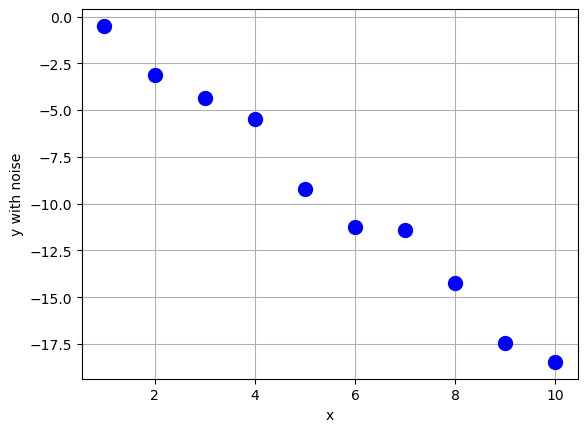

In [3]:
# let's have a first look at our data
plt.plot(x, y, 'bo', markersize=10)
plt.xlabel('x')
plt.ylabel('y with noise')
plt.grid()

Now that we have some noisy data, let's fit a linear regression and get the correlation coefficient and goodness of fit parameters. We'll start with an easy implementation in `numpy` using [`np.linalg.lstsq`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html).

> **Note:** In the theory section, we learned the simplest form of linear regression. In reality, for any higher order (e.g., polynomial) regressions we need to use **linear algebra** to solve a matrix-based least squares minimization problem, typically via [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition). The `lstsq` function is built on this and is not just restricted to linear problems, but can be used for quadratics and beyond!

In [4]:
# before we proceed with linear algebraic solving, 
# we need to create a matrix from our independent variable
M = np.vstack([x, np.ones(n)]).T

# what did we do here?
print(x)
print(M)

[ 1  2  3  4  5  6  7  8  9 10]
[[ 1.  1.]
 [ 2.  1.]
 [ 3.  1.]
 [ 4.  1.]
 [ 5.  1.]
 [ 6.  1.]
 [ 7.  1.]
 [ 8.  1.]
 [ 9.  1.]
 [10.  1.]]


Do we understand the step above? What does each part (e.g., `np.vstack`, `np.ones`, `.T`) do and in what order?

In [5]:
# the implementation of least squares regression to get our
# A and B estimates is now just one simple line!
coeffs, ssr, _, _ = np.linalg.lstsq(M, y, rcond=None)

You can see here (or in the function [documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html)) that `np.linalg.lstsq` **returns** (left side of equal sign) multiple values. In python, we can suppress the returns we don't need with the `_` notation. In this case we just want the regression coefficients (`coeffs`) and the sum of squared residuals (`ssr`). Another way to write the above line is: 
    
    coeffs, ssr = np.linalg.lstsq(M, y, rcond=None)[0:2]

In [6]:
# let's look at our coefficients by unpacking the array
# the coefficients are ordered slope, intercept
# NOTE - we can unpack the array using comma separated values
B_est, A_est = coeffs

print('true B : {:0.2f}, predicted B : {:0.2f}'.format(B, B_est))
print('true A : {:0.2f}, predicted A : {:0.2f}'.format(A, A_est))

true B : -2.00, predicted B : -2.01
true A : 1.00, predicted A : 1.49


In [7]:
# Now we can calculate predicted y values 
# using our estimates for slope and intercept
y_est = A_est + B_est * x

\begin{equation}
  \large
  SSR = \sum_{i=1}^{n}{(y_i - f(x_i))^2}
\end{equation}

In [8]:
# and we can get the residuals
resid = y - y_est

In [9]:
# and the squared residuals
sqr_resid = resid ** 2

In [10]:
# and the sum of squared residuals
sum_sqr_resid = np.sum(sqr_resid)

In [11]:
# and compare our calculation with numpy
print(np.isclose(ssr, sum_sqr_resid))

[ True]


\begin{equation}
    \large
    r = \frac{\sum_{i=1}^{n}{\left(x_{i} - \bar{x} \right)\left(y_{i} - \bar{y} \right)}}{\sqrt{\sum_{i=1}^{n}{\left(x_{i} - \bar{x} \right)^2} \sum_{i=1}^{n}{\left(y_{i} - \bar{y} \right)^2}}}
\end{equation}

\begin{equation}
    \large
    R^2 = 1 - \frac{\sum_{i=1}^{n}{(y_i - f(x_i))^2}}{\sum_{i=1}^{n}{(y_i - \bar{y})^2}}
\end{equation}

\begin{equation}
    \large
    MSE = \frac{SSR}{n-p}
\end{equation}

\begin{equation}
    \large
    RMSE = \sqrt{\frac{SSR}{n-2}}
\end{equation}

In [12]:
# also from the theory equations we can calculate the:

# r (correlation coefficient)
r = (np.sum((x - x.mean()) * (y - y.mean())) / 
     (np.sum((x - x.mean()) ** 2) * 
      np.sum((y - y.mean()) ** 2)) ** 0.5)

# r2 (coefficient of determination)
r2 = 1 - sum_sqr_resid / np.sum((y - y.mean()) ** 2)
# alternatively: r2 = r**2

# MSE (mean square error)
mse = sum_sqr_resid / (n - 2)

# RMSE (root mean square error)
rmse = np.sqrt(mse)

Now we can plot everything

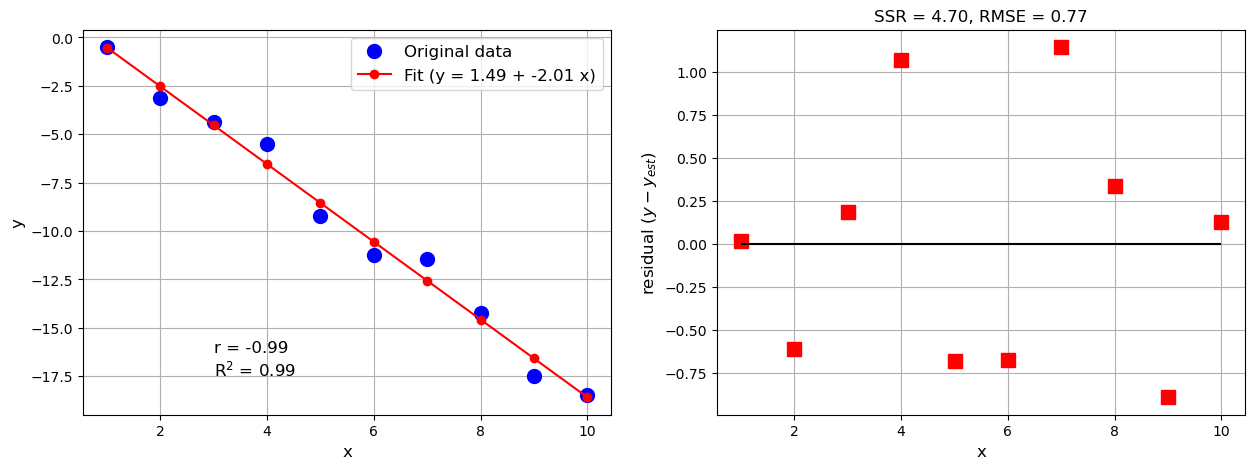

In [13]:
# we can also look at the fit and the residuals in a dual panel plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# NOTE - here we unpack the axes object to get convenient plotting names
ax1, ax2 = axes 

# same plot as above goes on the first axis (left side)
ax1.plot(x, y, 'bo', label='Original data', markersize=10)
ax1.plot(x, y_est, 'ro-', 
         label='Fit (y = {:0.2f} + {:0.2f} x)'.format(A_est, B_est))
ax1.text(x[2], y[-2], 'r = {:0.2f}\nR$^2$ = {:0.2f}'.format(r, r2), fontsize=12)
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid()

# and on the second axis (right side) we put the residuals
ax2.plot(x, resid, 'rs', label='Residuals', markersize=10)

# include a horizontal 0 line
ax2.hlines(0, x.min(), x.max(), color='k')

# add the plot elements
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('residual ($y-y_{est}$)', fontsize=12)
ax2.grid()

# let's put the SSR and RMSE metrics in the title of the residual plot
ax2.set_title('SSR = {:0.2f}, RMSE = {:0.2f}'.format(sum_sqr_resid, rmse));

<div class="alert alert-block alert-warning">
<b>Task 5.1</b>

Put the numpy least squares regression and calculation of correlation and goodness-of-fit parameters together in a function definition that's easy to reuse with new x,y data. 

Create a new x array variable with 100 evenly spaced values between 0 and 50. Use the equation of a line with slope 1.5 and intercept 5 to calculate the y-values. Add Gaussian noise to the y-values with a mean of 0 and a standard deviation of 20. Use the function you defined to return the estimated parameters and statistics of the fit on this x,y data. Plot the results just as in the above figure.

## Regressions for arrays

In [129]:
# create time or space steps
x = np.arange(1, 101, 1)
x = np.repeat(x, 100, axis=0)
x = x.reshape(100,100)
# x = np.repeat(x, 100, axis=0).reshape(100,100)
x

array([[  1,   1,   1, ...,   1,   1,   1],
       [  2,   2,   2, ...,   2,   2,   2],
       [  3,   3,   3, ...,   3,   3,   3],
       ...,
       [ 98,  98,  98, ...,  98,  98,  98],
       [ 99,  99,  99, ...,  99,  99,  99],
       [100, 100, 100, ..., 100, 100, 100]])

In [130]:
# create random slope and y intercepts
A = np.random.normal(-1,1, size=len(x))
B = np.random.normal(-2,2, size=len(x))
y = A + B * x
y

array([[-8.67199535e-01, -2.90402238e+00, -7.80258244e+00, ...,
        -6.34037024e-01, -8.17181883e-01, -2.96915960e+00],
       [-5.59043405e-02, -4.50254530e+00, -1.40077838e+01, ...,
        -5.73159453e-01, -2.34244105e-01, -4.35515348e+00],
       [ 7.55390855e-01, -6.10106822e+00, -2.02129852e+01, ...,
        -5.12281881e-01,  3.48693673e-01, -5.74114736e+00],
       ...,
       [ 7.78284344e+01, -1.57960745e+02, -6.09707117e+02, ...,
         5.27108739e+00,  5.57277826e+01, -1.37410566e+02],
       [ 7.86397296e+01, -1.59559268e+02, -6.15912318e+02, ...,
         5.33196496e+00,  5.63107204e+01, -1.38796560e+02],
       [ 7.94510248e+01, -1.61157791e+02, -6.22117519e+02, ...,
         5.39284253e+00,  5.68936582e+01, -1.40182554e+02]])

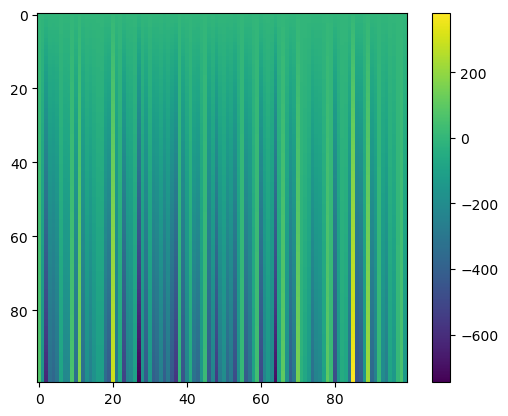

In [131]:
plt.imshow(y)
plt.colorbar()

(<matplotlib.image.AxesImage at 0x7cc81e751a30>,
 <matplotlib.colorbar.Colorbar at 0x7cc81e37ac90>)

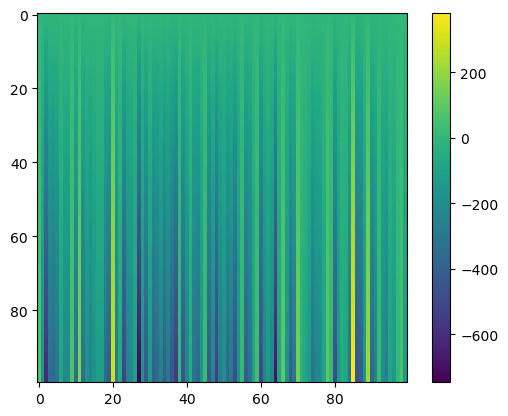

In [132]:
# let's also add some normal (Gaussian) noise 
# with mean=0 and standard deviation=1
np.random.seed(42) # this line allows for reproducible creation of the same random numbers
noise = np.random.normal(0, 1, size=(len(x), len(y)) )
y = y + noise
plt.imshow(y), plt.colorbar()

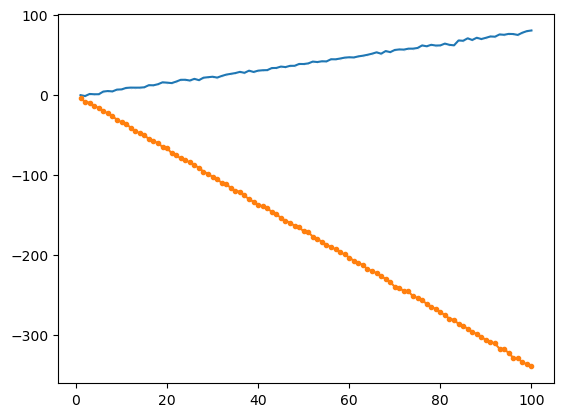

In [153]:
plt.plot(x[:,0], y[:,0])
plt.plot(x[:,10], y[:,10])

In [134]:
x = np.expand_dims(x, 2)
print(x.shape)

(100, 100, 1)


In [135]:
x1 = np.ones(x.shape[0:2])
x1 = np.expand_dims(x1, 2)
print(x1.shape)

(100, 100, 1)


In [140]:
M = np.concatenate( [x, x1], axis=2)
M[:,1]

array([[  1.,   1.],
       [  2.,   1.],
       [  3.,   1.],
       [  4.,   1.],
       [  5.,   1.],
       [  6.,   1.],
       [  7.,   1.],
       [  8.,   1.],
       [  9.,   1.],
       [ 10.,   1.],
       [ 11.,   1.],
       [ 12.,   1.],
       [ 13.,   1.],
       [ 14.,   1.],
       [ 15.,   1.],
       [ 16.,   1.],
       [ 17.,   1.],
       [ 18.,   1.],
       [ 19.,   1.],
       [ 20.,   1.],
       [ 21.,   1.],
       [ 22.,   1.],
       [ 23.,   1.],
       [ 24.,   1.],
       [ 25.,   1.],
       [ 26.,   1.],
       [ 27.,   1.],
       [ 28.,   1.],
       [ 29.,   1.],
       [ 30.,   1.],
       [ 31.,   1.],
       [ 32.,   1.],
       [ 33.,   1.],
       [ 34.,   1.],
       [ 35.,   1.],
       [ 36.,   1.],
       [ 37.,   1.],
       [ 38.,   1.],
       [ 39.,   1.],
       [ 40.,   1.],
       [ 41.,   1.],
       [ 42.,   1.],
       [ 43.,   1.],
       [ 44.,   1.],
       [ 45.,   1.],
       [ 46.,   1.],
       [ 47.,   1.],
       [ 48.,

In [142]:
y[:,0]

array([-0.37048538, -1.47127508,  1.11317821,  0.73769104,  0.78355359,
        4.11545399,  4.75756025,  4.28914381,  6.56144583,  6.80313053,
        8.64510785,  9.05505772,  8.99356731,  9.01154755,  9.44402221,
       12.08058947, 11.93062714, 13.27544888, 15.63730466, 15.24436357,
       14.68352609, 16.54640909, 18.78564286, 18.84453757, 17.88214759,
       19.98579334, 18.34992283, 21.42457925, 22.03290044, 22.61484887,
       21.56384876, 23.57605894, 25.27942224, 26.24409478, 27.20826655,
       28.7087732 , 27.515492  , 30.21589465, 28.57347532, 30.21719432,
       30.72111466, 30.8956816 , 33.45085588, 33.59489527, 35.31709428,
       34.68230578, 36.23641891, 36.27080863, 38.5819901 , 38.49438825,
       39.27380053, 41.5376244 , 40.98937571, 41.92277743, 41.75497576,
       44.45717873, 44.37712895, 45.35113245, 46.48315435, 46.92899661,
       46.69643081, 48.03395106, 48.8808413 , 50.02279806, 51.38580674,
       53.09426196, 51.38880275, 54.68066921, 53.3519209 , 56.05

In [144]:
print(M.shape[0])

100


In [185]:
#storing only the regression coefficients
X_lstsq = np.asarray([ np.linalg.lstsq(M[:,i], y[:,i], rcond=None)[0] for i in range(M.shape[0])])

In [150]:
print(X_lstsq.shape)
print(x.shape)
print(M.shape)
print(y.shape)

(100, 2)
(100, 100, 1)
(100, 100, 2)
(100, 100)


In [190]:
i = 10
B_est, A_est = X_lstsq[i,0], X_lstsq[i,1]
y_est = A_est + B_est * M[:,i,0]
y_est

array([  -3.55912658,   -6.95011769,  -10.3411088 ,  -13.73209991,
        -17.12309102,  -20.51408213,  -23.90507324,  -27.29606435,
        -30.68705546,  -34.07804657,  -37.46903768,  -40.86002879,
        -44.2510199 ,  -47.64201101,  -51.03300212,  -54.42399323,
        -57.81498434,  -61.20597545,  -64.59696656,  -67.98795767,
        -71.37894878,  -74.76993989,  -78.160931  ,  -81.55192211,
        -84.94291322,  -88.33390433,  -91.72489544,  -95.11588655,
        -98.50687766, -101.89786877, -105.28885988, -108.67985099,
       -112.0708421 , -115.46183321, -118.85282432, -122.24381543,
       -125.63480654, -129.02579765, -132.41678876, -135.80777987,
       -139.19877098, -142.58976209, -145.9807532 , -149.37174431,
       -152.76273542, -156.15372653, -159.54471764, -162.93570875,
       -166.32669986, -169.71769097, -173.10868208, -176.49967319,
       -179.8906643 , -183.28165541, -186.67264652, -190.06363763,
       -193.45462874, -196.84561985, -200.23661096, -203.62760

In [188]:
y_est.shape

(100,)

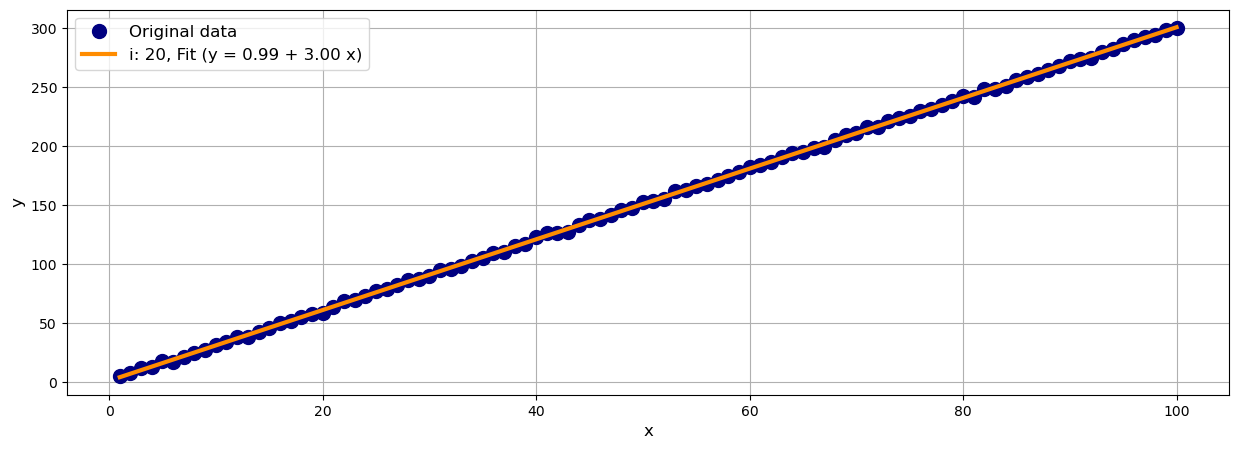

In [194]:
i=20
B_est, A_est = X_lstsq[i,0], X_lstsq[i,1]
y_est = A_est + B_est * M[:,i,0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
ax.plot(M[:,i,0], y[:,i], 'o', color='navy', label='Original data', markersize=10)
ax.plot(M[:,i,0], y_est, '-', color='darkorange', lw=3,
         label='i: {:d}, Fit (y = {:0.2f} + {:0.2f} x)'.format(i, A_est, B_est))
ax1.text(x[2], y[-2], 'r = {:0.2f}\nR$^2$ = {:0.2f}'.format(r, r2), fontsize=12)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.legend(fontsize=12)
ax.grid()


___
# `scipy` Least Squares

The above example with `numpy` is one way to calculate the least squares linear solution, but there are other ways. This is a good opportunity to introduce the powerful python library `scipy`, which contains a lot of advanced math functions, particularly for fitting regressions to data. In fact, `scipy` has a very easy-to-use implementation of linear regression contained in its `stats` module (see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html)):

In [195]:
# first create an array of x values, our independent variable
x = np.arange(1, 11, 1)

# now generate a linear regression using KNOWN constants
A = 1
B = -2
y = A + B * x

# let's also add some normal (Gaussian) noise 
# with mean=0 and standard deviation=1
np.random.seed(0) # this line allows for reproducible creation of the same random numbers
noise = np.random.normal(0, 1, size=len(y))
y = y + noise

# get the size of the data
n = x.size

# now use scipy to get the linear regression
B_est, A_est, r, _, _ = stats.linregress(x, y)

# calculate the estimate
y_est = A_est + B_est * x

# get r2
r2 = r**2

<div class="alert alert-block alert-warning">
<b>Task 5.2</b>

Calculate the $RMSE$. You'll need the residuals and the equation for $SSR$ and $RMSE$ above.
</div>

Let's plot the results of scipy's method.

slope (B) : -2.17
intercept (A) : 2.67
correlation (r) : -0.99
coeff of det. (R^2) : 0.98
RMSE : 0.77


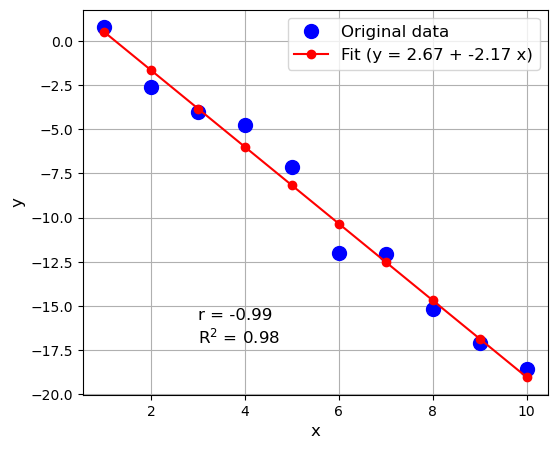

In [196]:
# now have a look at the results
print('slope (B) : {:0.2f}'.format(B_est))
print('intercept (A) : {:0.2f}'.format(A_est))
print('correlation (r) : {:0.2f}'.format(r))
print('coeff of det. (R^2) : {:0.2f}'.format(r2))
print('RMSE : {:0.2f}'.format(rmse))

# this is the same plotting block we used before
fig, ax1 = plt.subplots(figsize=(6, 5))
ax1.plot(x, y, 'bo', label='Original data', markersize=10)
ax1.plot(x, y_est, 'ro-', 
         label='Fit (y = {:0.2f} + {:0.2f} x)'.format(A_est, B_est))
ax1.text(x[2], y[-2], 'r = {:0.2f}\nR$^2$ = {:0.2f}'.format(r, r2), fontsize=12)
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid()

Great! The plots and values are identical in the numpy and scipy implementations. This is just another example of the fact that there are often many ways to accomplish a task in python.

> **Note:** Python is open source. That means for any function you can see its **source code** if you're interested in what's going on "under the hood". For `scipy.stats.linregress()`, clicking on "source" in the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) brings us [here](https://github.com/scipy/scipy/blob/v1.5.2/scipy/stats/_stats_mstats_common.py#L15-L144). If you scroll past the docstring you may be able to see some similar calculations from the theory section above.

___
# 'statsmodels' regression

[statsmodels](https://www.statsmodels.org/stable/index.html#) Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. An extensive list of result statistics are available for each estimator.

It is very powerful, but also somewhat slow. It works seamlessly with pandas.


In [199]:
!conda install -y -c conda-forge statsmodels

Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/bodo/miniconda3/envs/tensorflow

  added / updated specs:
    - statsmodels


The following NEW packages will be INSTALLED:

  patsy              conda-forge/noarch::patsy-1.0.1-pyhd8ed1ab_1 
  statsmodels        conda-forge/linux-64::statsmodels-0.14.4-py312hc0a28a1_0 

The following packages will be UPDATED:

  ca-certificates    pkgs/main/linux-64::ca-certificates-2~ --> conda-forge/noarch::ca-certificates-2025.4.26-hbd8a1cb_0 
  certifi                            2025.1.31-pyhd8ed1ab_0 --> 2025.4.26-pyhd8ed1ab_0 
  openssl                                  3.5.0-h7b32b05_0 --> 3.5.0-h7b32b05_1 




Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [200]:
import statsmodels.api as sm

#let's generate the same test data as before
x = np.arange(1, 11, 1)
# now generate a linear regression using KNOWN constants
A = 1
B = -2
y = A + B * x
# let's also add some normal (Gaussian) noise 
# with mean=0 and standard deviation=1
np.random.seed(0) # this line allows for reproducible creation of the same random numbers
noise = np.random.normal(0, 1, size=len(y))
y = y + noise

X = sm.add_constant(x)
results = sm.OLS(y, X).fit()

In [201]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     446.3
Date:                Sun, 11 May 2025   Prob (F-statistic):           2.65e-08
Time:                        10:18:24   Log-Likelihood:                -12.380
No. Observations:                  10   AIC:                             28.76
Df Residuals:                       8   BIC:                             29.37
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6738      0.637      4.195      0.0

/home/bodo/miniconda3/envs/tensorflow/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


## Weighted linear regression

In [204]:
sm.WLS?

Init signature: sm.WLS(endog, exog, weights=1.0, missing='none', hasconst=None, **kwargs)
Docstring:     
Weighted Least Squares

The weights are presumed to be (proportional to) the inverse of
the variance of the observations.  That is, if the variables are
to be transformed by 1/sqrt(W) you must supply weights = 1/W.

Parameters
----------
endog : array_like
    A 1-d endogenous response variable. The dependent variable.
exog : array_like
    A nobs x k array where `nobs` is the number of observations and `k`
    is the number of regressors. An intercept is not included by default
    and should be added by the user. See
    :func:`statsmodels.tools.add_constant`.
weights : array_like, optional
    A 1d array of weights.  If you supply 1/W then the variables are
    pre- multiplied by 1/sqrt(W).  If no weights are supplied the
    default value is 1 and WLS results are the same as OLS.
missing : str
    Available options are 'none', 'drop', and 'raise'. If 'none', no nan
    checking

In [207]:
results = sm.WLS(y, X, weights=y**2).fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.966
Model:                            WLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     224.2
Date:                Sun, 11 May 2025   Prob (F-statistic):           3.91e-07
Time:                        10:22:30   Log-Likelihood:                -15.477
No. Observations:                  10   AIC:                             34.95
Df Residuals:                       8   BIC:                             35.56
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6756      1.146      1.462      0.1

/home/bodo/miniconda3/envs/tensorflow/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


___
# Uncertainties and Significance

_Note: This section is necessarily brief, as this is a BIG topic._

Okay, now back to a bit more theory. We have a linear regression, a measure of correlation, and we have some goodness of fit parameters. But how can we know that our fit is statistically significant? For this we need to consider **alternative hypotheses** and **uncertainty** in our estimates.

## Hypothesis Testing

We want to validate our results by asking: Is the correlation ($r$-value) between $x$ and $y$ statistically significant? The basic structure of [**hypothesis testing**](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing) is as follows:

1. Turn the question into a pair of hypotheses:
    - The **null hypothesis** says there is no correlation and the estimate is a result of random chance.
    - The **alternative hypothesis** says the correlation is non-zero and significant.
2. Assume `null == True`.
3. Measure a property (**test statistic**) of the data that depends on the null hypothesis.
4. Determine the distribution of values that test statistic can take given the null hypothesis.
5. Use that distribution to determine the probability of measuring a test statistic at least as extreme as the one measured in the data. This probability is your **$p$-value**!
6. A large $p$-value means you cannot rule out the null hypothesis and the observed correlation may still be false. A small $p$-value means that the null hypothesis is unlikely. $p$ is "small" when it is below some **confidence level** $\alpha$, which is often set at $\alpha=0.05$, or the 95% confidence. In "code":

```
if p < 0.05:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")
```

> **Note: The $p$-value is an imperfect metric that is [often abused](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5738950/). See [this comment](https://media.nature.com/original/magazine-assets/d41586-019-00857-9/d41586-019-00857-9.pdf) in the journal Nature. You should also report goodness of fit parameters and other dataset characteristics.**

## Linear Regression Case

So if we think $x$ and $y$ are related,
1. We create a null $H_0$ and alternative $H_A$ hypothesis:
    * $H_0$: $B=0$ or $H_A$: $B\neq0$ 
2. We assume $H_0$ they are not related (slope is 0)
3. Measure the slope $B$ of the best fit line between $x$ and $y$
4. Determine the probability of measuring a slope $M$ if the slope is actually zero
5. Compute $p=Pr(M>|B|)$
6. Reject the idea of a zero slope if $p$ is small.

If the null hypothesis is rejected, this supports, but does not prove, the original hypothesis.

Let's look at a quick example of this idea in practice to manually calculate a $p$-value.

In [ ]:
# first create some very noisy data
np.random.seed(42)
x = 2 * np.random.randn(100) + 0.5
y = 4 * np.random.randn(100) + 0.5 * x

# now use scipy to get the linear regression
slope, intercept, r, _, _ = stats.linregress(x, y)

# plot it
plt.plot(x, y, 'o', label=None)
plt.plot(x, slope * x + intercept, 'r-', lw=2, label="Regression")
plt.xlabel("x")
plt.ylabel("y")
plt.title('The original data')

Now we can force there to be no apparent relationship in the data by shuffling the y values

In [ ]:
yr = y.copy()

np.random.shuffle(yr)

slope_R, intercept_R, _, _, _ = stats.linregress(x, yr)

plt.title("Randomized Y vs. X")
plt.plot(x, yr, 'o', label=None)
plt.plot(x, slope_R * x + intercept_R, 'r-', lw=2, label="Regression")
plt.xlabel("x")
plt.ylabel("y")

This is somewhat similar and we might still find a correlation between the values, but what if we do this shuffling a few hundred or thousand times?

In [ ]:
# randomize Y vs X many times, get slope of each:
list_R_slopes = []
for _ in range(1000):
    yr = y.copy()
    np.random.shuffle(yr)
    slope_R = stats.linregress(x, yr)[0]
    list_R_slopes.append(slope_R)

We'll need to calculate the CDF or **cumulative distribution function** of the estimated slopes on the shuffled data. We'll talk more about distributions in the coming lesson.

In [ ]:
x_cdf = sorted(list_R_slopes)
N = len(x_cdf)
y_cdf = [ (N-1.0-i)/N for i in range(N) ]

plt.figure(figsize=(8, 6))
plt.title("Distribution of slopes if random", fontsize=14)
plt.plot(x_cdf, y_cdf, '.-')
plt.plot( [slope, slope], [0,1], 'k--', label='Estimated slope on real data' )
plt.xlabel("Slope", fontsize=16)
plt.ylabel("P (Shuffled slope > Slope)", fontsize=16)
plt.legend(fontsize=12);
# plt.xlim(0.1, 0.3)
# plt.ylim(0.1, 0.2)

As we can see, our randomly shuffled data had many slope values that were estimated to be even steeper than the original data. We can use these simulations to estimate the probability that we see a slope at least as extreme (meaning as positive or negative, hence the `abs` below) as the real slope in our random data, under the null hypothesis that there is no correlation between the data.

In [ ]:
more_extreme_slopes = [si for si in list_R_slopes if abs(si) >= slope]
probability_of_more_extreme = len(more_extreme_slopes) / len(list_R_slopes)

print('our p-value is: {:.3f}'.format(probability_of_more_extreme))

This value is a $p$-value, and it is well above a confidence level of say 0.05. This tells us that there may in fact be no correlation in our noisy synthetic data.

What if we go back and make the relationship a bit less noisy by modifying our original y values (i.e., change the factor of 4 to 2)?

This is just one simple and instructive example of hypothesis testing to obtain a $p$-value in linear regressions, and many others exist that depend on the distribution of a given test statistic.

## Standard Error

Aside from hypothesis testing and $p$-values, it's also useful to get uncertainties on our parameter ($A$ and $B$) estimates.

> **Note:** If there is confusion with the next two sections, it is recommended to carefully read [James Kirchner's derivation sheet](http://seismo.berkeley.edu/~kirchner/eps_120/Toolkits/Toolkit_10.pdf).

In order to get uncertainty estimates on our fitted slope and intercept parameters, we can calculate the [standard error of a parameter](https://en.wikipedia.org/wiki/Standard_error) $s$, which is related to the standard deviation $\sigma$ by: 

\begin{equation}
    \large
    s=\frac{\sigma}{\sqrt{n}}
\end{equation}

See [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1255808/) for a good description of the difference between standard deviation and standard error... or watch this helpful [YouTube video](https://www.youtube.com/watch?v=A82brFpdr9g). 

In general, standard deviation indicates dispersion of the data about the mean, whereas standard error quantifies uncertainty in the estimate of the mean, which is dependent on the sample size: more samples $n$ lead to lower standard error. This standard error is subtly different than the $RMSE$, which is the standard error of the regression, as it is concerned with the uncertainty on the fitted coefficients ($A$ and $B$), rather than the spread of the residuals. On its own, the standard error does not convey much meaning, but we can use this value to construct **confidence intervals.**


## $t$-statistic and Confidence Intervals

One hypothesis testing statistic widely used in linear regression is the [$t$-statistic](https://en.wikipedia.org/wiki/T-statistic), applied in the [Student's $t$-test](https://en.wikipedia.org/wiki/Student%27s_t-test). In our minimal python example we used shuffled permutations of the data and the distribution of slopes, but in practice this would be too costly to calculate over every shuffling of y values.

$t$ is defined as the ratio of the departure of the estimated value of a parameter from its hypothesized value to its standard error. This assumes that the distribution of _residuals_ is normal, which is often but not always the case. Thus for a given parameter like the estimated slope $B$, we can calculate the $t$-statistic by:

\begin{equation}
    \large
    t = \frac{B - B_0}{s_B}
\end{equation}

where $B_0$ is some known constant, which is 0 under the null hypothesis of zero slope, and $s_B$ is the standard error of the estimated slope. This is essentially asking: _what is the number of standard errors that $B$ differs from a slope of 0?_ 

Using the equation of $s_B$ ([see James Kirchner's derivation sheet](http://seismo.berkeley.edu/~kirchner/eps_120/Toolkits/Toolkit_10.pdf)), this can be written as:

\begin{equation}
    \large
    t = r\frac{\sqrt{n-2}}{\sqrt{1 - r^2}}
\end{equation}

One can use a [$t$-table](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Table_of_selected_values) to evaluate the significance level for this value compared to $t_{\alpha,(n-2)}$ (some critical t-value), where the subscript represents the chosen $\alpha$ and the given degrees of freedom ($n-2$ for linear regression). From this comparison, a $p$-value can be calculated, which tells us how likely this correlation would arise by chance, or how close our t-value is to the critical t-value. For the 95% confidence level ($\alpha=0.05$), if $p>\alpha$ then we cannot reject the null hypothesis and the correlation may arise by chance.

A **confidence interval** $CI$ lets us define the range of numbers over which we are confident the true value of our regression estimates lie. For linear regression we can write down exactly what the confidence intervals are for the slope (or intercept) estimate using:

\begin{equation}
    \large
    CI = B \pm t_{\alpha,(n-2)} s_{B}
\end{equation}

___
# Uncertainties in Python

Luckily we don't need to keep all this theory in mind as python packages make the calculations of $p$ and confidence intervals straightforward. Nevertheless, the theoretical underpinnings and equations are good to see!

Let's return to our previous example using scipy and see how we can easily get a grasp of the uncertainties in our fit.

In [ ]:
# first create an array of x values, our independent variable
x = np.arange(1, 11, 1)

# now generate a linear regression using KNOWN constants
A = 1
B = -2
y = A + B * x

# let's also add some normal (Gaussian) noise 
# with mean=0 and standard deviation=1
np.random.seed(0) # this line allows for reproducible creation of the same random numbers
noise = np.random.normal(0, 1, size=len(y))
y = y + noise

# get the size of the data
n = x.size

fig, ax1 = plt.subplots(figsize=(6, 5))
ax1.plot(x, y, 'bo', label='Original data', markersize=10)
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid()

In [ ]:
stats.linregress(x, y)

We can get the $p$-value directly from the function! This function also provides us with the standard error, but we need to use a new way to return function results to have access to all this information (this was done for interoperability with older versions of scipy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html).

In [ ]:
# now call the function but have it output p also
# B_est, A_est, r, p, se = stats.linregress(x, y)
res = stats.linregress(x, y)
res.stderr

In [ ]:
# let's just separate those variables back out
B_est, A_est, r, p, se_B, se_A = res.slope, res.intercept, res.rvalue, res.pvalue, res.stderr, res.intercept_stderr

In [ ]:
# calculate the estimate and RMSE
y_est = A_est + B_est * x
ssr = np.sum((y - y_est) ** 2)
rmse = np.sqrt(ssr / (n - 2))

Let's quickly calculate our t-statistic for the slope:

\begin{equation}
    \large
    t = r\frac{\sqrt{n-2}}{\sqrt{1 - r^2}}
\end{equation}

In [ ]:
# calculate t for the linear regression slope
t_slope = r * np.sqrt(n - 2) / np.sqrt(1 - r**2)
print('t-statistic for the slope is: {}'.format(t_slope))
print('degrees of freedom: {}'.format(n - 2))

And let's just check this derived equation matches the original:

\begin{equation}
    \large
    t = \frac{B - B_0}{s_B}
\end{equation}

In [ ]:
t_slope2 = B_est / se_B
print('t-statistic for the slope is: {}'.format(t_slope2))

From this we can see that the estimated slope differs from a 0 slope by several tens of standard errors, thus we may expect a small probability that the correlation arises by chance. What if we wanted to say that there is a 95% probability that the regression does not arise by chance given this t-statistic and degrees of freedom. We can look this up in the [t-table by finding the critical t-value](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Table_of_selected_values)... Let's look this value up, and let's also go back up and change the number of points and noise levels to see how it changes our slope t-statistic and our confidence.

Alternatively to all this hard thinking, we can just use the output from scipy to determine our exact $p$-value...

In [ ]:
# print the p-value with 10 digits after the decimal
print('p is {:.10f}'.format(p))

Nice! The `linregress` function takes care of the hypothesis test (in this case using the [Wald test](https://en.wikipedia.org/wiki/Wald_test), which is similar to the t-test) for us and returns a $p$-value, which in this case is really small, thus we can say that the null hypothesis is rejected, as expected given the tight fit. 

Now we can calculate the confidence intervals on the estimate using the standard error and the $t$-value at a given confidence level.

\begin{equation}
    \large
    CI = B \pm t_{\alpha,(n-2)} s_{B}
\end{equation}

In [ ]:
# set the confidence level, 0.05 is 95%
alpha = 0.05

# use scipy to look up the t-value for given confidence and degrees of freedom
t_critical = stats.t.ppf(1 - (alpha/2), n - 2)

print("critical t-value at {:.1f}% confidence with {} degrees of freedom: {:.3f}".format(100*(1 - alpha), n - 2, t_critical))
print("slope (95%): {:.2f} +/- {:.2f}".format(B_est, t_critical * se_B))
print("intercept (95%): {:.2f} +/- {:.2f}".format(A_est, t_critical * se_A))

Let's plot the results with our new statistics

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 5))
ax1.plot(x, y, 'bo', label='Original data', markersize=10)
ax1.plot(x, y_est, 'r-', 
         label='Fit: y = {:0.2f} ($\pm${:0.2f}) + {:0.2f} ($\pm${:0.2f}) x'\
         .format(A_est, t_critical * se_A, B_est, t_critical * se_B))

# and let's put the fit values in the title
ax1.set_title('r = {:0.2f}\nR$^2$ = {:0.2f}\nRMSE = {:0.2f}\np-val = {:.3e}'.format(r, r**2, rmse, p))

ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid()

<div class="alert alert-block alert-warning">
<b>Task 5.3</b>

Run the above regression a few times changing the standard deviation of the Gaussian noise to values of 1, 10, and 100 and also increasing the sample size from 10 to 100. You can use the compact code below. What do you notice? What is the relation between the $p$-value and $R^2$?
</div>

In [ ]:
# SET THESE VARIABLES #
sample_sz = 
gauss_std = 
#######################

x = np.arange(1, sample_sz + 1, 1)
A = 1
B = -2
y = A + B * x

np.random.seed(0)
noise = np.random.normal(0, gauss_std, size=len(y))
y = y + noise

n = x.size
B_est, A_est, r, p, _ = stats.linregress(x, y)
y_est = A_est + B_est * x
ssr = np.sum((y - y_est) ** 2)
rmse = np.sqrt(ssr / (n - 2))

fig, ax1 = plt.subplots(figsize=(6, 5))
ax1.plot(x, y, 'bo', label='Original data', markersize=10)
ax1.plot(x, y_est, 'r-', 
         label='Fit (y = {:0.2f} + {:0.2f} x)'.format(A_est, B_est))
ax1.set_title('r = {:0.2f}\nR$^2$ = {:0.2f}\nRMSE = {:0.2f}\np-val = {:.2e}'.format(r, r**2, rmse, p))
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid()

The relation between $p$ and $R^2$ shows that even for very noisy data with low $R^2$ values, statistically significant correlations can exist.

___
# Linear Regression on Real Data

Let's get back to our climate data from Berlin. The goal here is to plot some linear regressions on the monthly temperature time series that we prepared in the last notebook.

<div class="alert alert-block alert-warning">
<b>Task 5.4</b>

Load the monthly data from our climate HDF file from the `data/climate_templhof` folder. Put it in a pandas dataframe called `monthly`.
</div>

In [ ]:
print(monthly.head())

Let's also sort the data into ascending time order. We can use the dataframe `sort_values` method and pass a list that tells it "sort by the first value in this list THEN sort by the following value."

In [ ]:
monthly = monthly.sort_values(['year', 'month'])

Let's also give the dataframe a date-month combined column and convert it to a datetime object, which will make for easier plotting.

In [ ]:
# here we use a combination of "zip", string formating, and list comprehension
# to get a new column of year-month strings in the dataframe as a "tmp" or
# temporary column
monthly['tmp'] = ['{:.0f}-{:.0f}'.format(y, m) for y, m in zip(monthly.year, monthly.month)]

The above line is a bit complex, what would that look like written out in a for loop? Let's think about it and briefly discuss.

In [ ]:
# now we will call "to_datetime" and also append this call with a 
# function called "to_period", which we pass "M" to (meaning monthly)
monthly['datetime'] = pd.to_datetime(monthly['tmp']).dt.to_period('M')

# and let's delete the temporary column 
del monthly['tmp']

> **Note:** This is the first time we use the built in python function **`del`** or delete. You can use it to delete variables from your current python namespace or to remove items from python containers like lists, or, in this case, a pandas dataframe.

In [ ]:
print(monthly.head())

In [ ]:
monthly.dtypes

Now that our data is prepped, we can have a closer look and decide what we want to regress on. First let's look at all the data together:

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
monthly.plot(x='datetime', y='mean_temp_C', ax=ax, style='-')
ax.set_ylabel('monthly mean temp (C)')
ax.set_xlabel('time (months and years)')
ax.grid()

Okay, we can see in this plot the strong seasonal oscillation. That would really complicate any simple linear regression and require us to remove the seasonal signal before proceeding. However, let's not go down that road just yet! 

For this exercise, let's just extract the warm summer months and do some regression on them.

## Aggregate Summer Temperatures

<div class="alert alert-block alert-warning">
<b>Task 5.5</b>

Form a new dataframe called `summer`. It should only contain monthly data from June, July, and August. You should also reset the index on the new dataframe.
</div>

Let's have a look at our summer data alone

In [ ]:
print(summer.head())

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
summer.plot(x='datetime', y='mean_temp_C', ax=ax, style='.-')
ax.set_ylabel('summer mean temp (C)', fontsize=14)
ax.set_xlabel('time (months and years)', fontsize=14)
ax.grid()

There's still a lot of oscillation here (not to mention the un-even x-axis spacing), so let's reduce each summer to a single mean temperature value use the `groupby` method.

In [ ]:
# group the summer dataframe by year
grouped = summer.groupby(["year"])

In the last notebook we saw how we could loop over the groupby object. We also saw how we could gain speed by calling functions directly on the groupby object (e.g., `grouped_object['column_name'].mean()`). Let's see another neat way to calculate multiple grouped statistics for one column. In this case we want to get the mean and the standard deviation of the 3 months that make up each Summer. 

> **Note:** We can use this standard deviation column to put some uncertainties on our measurements when we do **weighted regressions** during the semester.

For this operation we'll use pandas `agg` (for aggregate) method:

In [ ]:
# get an aggregated summer dataframe
# call the "agg" method on the grouped object
# here we are telling agg to calculate the mean and std
# or standard deviation of the 'mean_temp_C' column
summer_agg = grouped.agg({'mean_temp_C':['mean','std']})

print(summer_agg.head())

## Regression: 1948-2019

To make our life easier, let's also just go ahead and extract our relevant data as variables now. That way we won't need to keep calling the dataframe and can have some succinct (and thus readable) variable names for further analysis.

In [ ]:
# extract our data of interest to make plotting easier
# NOTE - we use the "values" call on the end to make sure
# we end up with a numpy array and not another Series object
x = summer_agg.index.to_numpy(copy=True)
y = summer_agg[('mean_temp_C', 'mean')].to_numpy(copy=True)
print(x[0:5])
print(y[0:5])

# size of data
n = x.size

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(x, y, '-')
ax.set_ylabel('summer mean temp (C)', fontsize=14)
ax.set_xlabel('time (years)', fontsize=14)
ax.grid()

Now that we have reduced the seasonal signal we can see a trend of increasing summer temperatures in the last ~30 years of data. Let's remove the connecting lines so we just see the raw data points

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(x, y, 'o')
ax.set_ylabel('summer mean temp (C)', fontsize=14)
ax.set_xlabel('time (years)', fontsize=14)
ax.grid()

First, let's do a linear regression on the entire aggregated time series.

<div class="alert alert-block alert-warning">
<b>Task 5.6</b>

Use the scipy function `stats.linregress` to calculate the slope, intercept, $r$-value, $p$-value, and standard error between our x (year) and y (temp) variables. Calculate the line estimate, $R^2$, $SSR$, and $RMSE$ from this output.
</div>

And let's not forget our fancy new uncertainty estimates!

In [ ]:
# set the confidence level, 0.05 is 95%
alpha = 0.05

# use scipy to look up the t-value for given parameters
t = stats.t.ppf(1 - (alpha/2), n - 2)

print("critical t-value at {:.1f}% confidence with {} degrees of freedom: {:.3f}"\
      .format(100*(1 - alpha), n - 2, t))
print("t-statistic for slope (number of standard errors that the slope differs from 0 slope): {:.3f}"\
      .format(r * np.sqrt(n - 2) / np.sqrt(1 - r**2)))

In [ ]:
# now have a look at the results

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(x, y, 'bo', label='Original data', markersize=10)
ax1.plot(x, y_est, 'r-', 
         label='Fit: y = {:0.2f} ($\pm${:0.2f}) + {:0.2f} ($\pm${:0.2f}) x'.format(A_est, t * se_A, B_est, t * se_B))

# and let's put the fit values in the title
ax1.set_title('r = {:0.2f}, R$^2$ = {:0.2f}, RMSE = {:0.2f}, p-val = {:.2e}'.format(r, r**2, rmse, p))

ax1.set_xlabel('year', fontsize=12)
ax1.set_ylabel('mean summer temp (C)', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid(lw=0.4)

# and save it out
# plt.savefig('figures/NB05_fig02_berlin_summer_temp_linreg_1948to2019.png', dpi=200)

What is the rate of temperature increase shown by this line (in units of $^\circ$C/yr)? And what is potential upper and lower rate?

Of course, the $R^2$ value shows a rather poor overall fit with a value of only 0.19, BUT, look at our $p$-value! In addition to this small $p$-value we can see that the $RMSE$ is telling us that the model is typically within approximately 1 degree of the true value for much of estimates, which is another good sign.

# Weighted Least Squares (WLS) Regression

As opposed to **ordinary least squares (OLS)**, which we covered extensively above, **weighted least squares (WLS)** takes into account uncertainties in our measured variables.

Up until now, we haven't considered any uncertainty in our variable measurement. Of course, the time (year) is pretty exact on the x-axis and we can disregard measurement error, but what if our temperature measurements were off? Or, in the case above, what if we wanted to include the June-July-August standard deviation in our plots and regression?

Let's have a look at those error bars now using a new matplotlib plotting method (you can see more examples of the `plt.errorbar()` function [here](https://matplotlib.org/1.2.1/examples/pylab_examples/errorbar_demo.html)):

In [ ]:
# get the standard deviation as y-error
y_err = summer_agg[('mean_temp_C', 'std')].to_numpy(copy=True)

In [ ]:
# re-plot our temperature time series with errorbars
fig, ax = plt.subplots(figsize=(12,6))

# new plot function alert!
ax.errorbar(x, y, yerr=y_err, fmt='bo', label='mean $\pm$ std')

ax.set_ylabel('summer mean temp (C)', fontsize=14)
ax.set_xlabel('time (years)', fontsize=14)
ax.grid()
ax.legend(fontsize=12)

Well this looks different. It's clear that in some years there were significant temperature swings between the Summer months. To take these **errors**, or **uncertainties**, into account we'll need to turn to **weighted regression** (which still relies on the least squares approach).

## Goodness-of-Fit With Uncertainties

Keeping in mind the idea that predictions should be within data uncertainties we can consider other basic goodness-of-fit calculations when we have uncertainties. The first example is the **weighted sum of the squared errors**, also often referred to simply as [**chi squared**](http://en.wikipedia.org/wiki/Chi-squared_distribution):

\begin{equation}
  \large
  \chi^{2} = \frac{1}{n} \sum_{i=1}^{n} \frac{(y_{i} - f(x_{i}))^{2}}{\sigma_{i}^{2}}
\end{equation}

where $n$ is the number of $x$-$y$ pairs, $y_i$ is the $i$-th observed $y$ value, $f(x_i)$ is the $i$-th estimated $y$ value, and $\sigma_{i}$ is the $i$-th standard deviation of $y$. If we include the degrees of freedom in the denominator ($n-2$ for linear regression): 

\begin{equation}
  \large
  \chi^{2} = \frac{1}{n - 2} \sum_{i=1}^{n} \frac{(y_{i} - f(x_{i}))^{2}}{\sigma_{i}^{2}}
\end{equation}

In WLS, this replaces the $SSR$ cost-function that we attempted to minimize in our OLS case, without uncertainties on the y-values.

This equation is similar to our sum of squared residuals $SSR$ equation. Conceptually this equation checks the residual between a measurement and divides it by the sample standard deviation. If the standard deviation is simply how much a value differs from the mean on average, then dividing by the standard deviation should allow us to see whether or not a prediction is within the uncertainty. Consider some examples with only one sample (so $n=1$):

1. If we assume that $y_i$ and $f(x_i)$ are identical, then their difference is zero, and the value of the chi-squared equation for that data point would also be zero.
2. If $f(x_i)$ is exactly 1 standard deviation larger or smaller than $y_i$, then the difference would be exactly the standard deviation $\sigma_i$, in which case the chi-squared value for that data point would be $\sigma^{2} / \sigma^{2}$, which equals 1.

A chi-squared value of 1 or less tells us that on average the predictions are within the uncertainties in the data, and a value of greater than 1 says that on average the predictions are not within the uncertainties of the data.

## Back to the Data

There are many ways to calculate weighted regressions (e.g., with fancy libraries like [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.WLS.html)), but we're going to use the `curve_fit` function contained in scipy's `optimize` module. This function is highly flexible and allows you to fit any user-defined function to pairs of data with uncertainty on the dependent variable. It estimates the regression coefficients using a non-linear least squares method and returns the optimal parameters and the covariance matrix, from which you can calculate uncertainties and goodness-of-fit metrics.

In [ ]:
# we first need to define a function that we pass to 
# curve_fit, this is our equation of a line in python form
def line_func(x, A, B):
    """
    take x values and return y values based on the
    intercept (A) and slope (B) parameters
    """
    return A + B * x

In [ ]:
# with our equation of a line defined we pass it, the x-y data,
# and the y uncertainties (as "sigma") to curve_fit
coeffs, cov = optimize.curve_fit(line_func, x, y, sigma=y_err)

# let's also unpack our coefficients tuple
# the order of them is as they were defined in the function definition
intercept_wls, slope_wls = coeffs

In [ ]:
# calculate the estimate
y_est_wls = line_func(x, intercept_wls, slope_wls)

# residual
residuals = y - y_est_wls

# get rmse
ssr = np.sum((residuals) ** 2)
n = x.size
rmse_wls = np.sqrt(ssr / (n - 2))

`curve_fit` doesn't give us a correlation coefficient value, but recalling our equations from ordinary least squares we can easily back calculate this (and an $R^2$ value along the way).

In [ ]:
# get total sum of squares
sst = np.sum((y - y.mean())**2)

# get r2
r2_wls = 1 - (ssr/sst)

# get r
r_wls = np.sqrt(r2_wls)

We can now use the above equation to calculate the chi-squared value

\begin{equation}
  \large
  \chi^{2} = \frac{1}{n - 2} \sum_{i=1}^{n} \frac{(y_{i} - f(x_{i}))^{2}}{\sigma_{i}^{2}}
\end{equation}

In [ ]:
# calculate chi-squared goodness-of-fit parameter
chisq = (1 / (n - 2)) * np.sum(residuals ** 2 / y_err ** 2)

# print the results
print("chisq: {:0.2f}".format(chisq))

And let's just do a quick check to see if our $t$-statistic for the new slope value is statistically significant at some confidence level...

In [ ]:
# set the confidence level, 0.05 is 95%
alpha = 0.05

# use scipy to look up the t-value for given parameters
t = stats.t.ppf(1 - (alpha/2), n - 2)

print("critical t-value at {:.1f}% confidence with {} degrees of freedom: {:.3f}"\
      .format(100*(1 - alpha), n - 2, t))
print("t-statistic for slope (number of standard errors that the slope differs from 0 slope): {:.3f}"\
      .format(r_wls * np.sqrt(n - 2) / np.sqrt(1 - r2_wls)))

Again, the t-statistic is well above the critical value, thus indicating that the slope is unlikely to have arisen by statistical chance

The covariance matrix output by `curve_fit` also allows us to place standard deviation errors on the coefficient estimates (slope and intercept) - see [here](https://stackoverflow.com/questions/25234996/getting-standard-error-associated-with-parameter-estimates-from-scipy-optimize-c/25235710#25235710). The diagonal values of the covariance matrix are the variance $\sigma^2$ of each variable. 

In [ ]:
# get the "sigma" for each variable
# "diag" extracts the diagonal elements
intercept_wls_sig, slope_wls_sig  = np.sqrt(np.diag(cov))

print("intercept +/- sigma : {:.02f} +/- {:.04f}".format(intercept_wls, intercept_wls_sig))
print("slope +/- sigma : {:.02f} +/- {:.04f}".format(slope_wls, slope_wls_sig))

We should note that the 95% confidence interval we calculated previously using our t-value and standard errors from `stats.linregress` should be close to twice the standard deviation, assuming our residuals are approximately normally distributed. Hence, we multiply them below.

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(x, y, 'bo', label='Original data', markersize=10)
ax1.plot(x, y_est, 'r-', 
         label='Fit: y = {:0.2f} ($\pm${:0.2f}) + {:0.3f} ($\pm${:0.3f}) x'.format(A_est, t * se_A, B_est, t * se_B))

# and let's put the fit values in the title
ax1.set_title('r = {:0.2f}, R$^2$ = {:0.2f}, RMSE = {:0.2f}, p-val = {:.2e}'.format(r, r**2, rmse, p))

ax1.set_xlabel('year', fontsize=12)
ax1.set_ylabel('mean summer temp (C)', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid(lw=0.4)

ax2.errorbar(x, y, yerr=y_err, fmt='bo', label='Original data (mean $\pm$ std)')
ax2.plot(x, y_est_wls, 'r-', 
         label='Fit: y = {:0.2f} ($\pm${:0.2f}) + {:0.3f} ($\pm${:0.3f}) x'\
         .format(intercept_wls, intercept_wls_sig * 2, slope_wls, slope_wls_sig * 2))

# and let's put the fit values in the title
ax2.set_title('WLS: r = {:0.2f}, R$^2$ = {:0.2f}, RMSE = {:0.2f}, chi-sqr = {:0.2f}'\
              .format(r_wls, r2_wls, rmse_wls, chisq))

ax2.set_xlabel('year', fontsize=12)
ax2.set_ylabel('mean summer temp (C)', fontsize=12)
ax2.legend(fontsize=12)
ax2.grid(lw=0.4)

It looks like there is still a correlation and temperature is increasing, but we see now that our $\chi^2$ value above 1 indicates that on average the fit is not within the uncertainty bounds of the data points. The correlation $r$ and $R^2$ are also reduced when including uncertainties, and the $RMSE$ is higher. This second view of the data shows us that we should be a bit cautious in our conclusions from linear regression. Certainly the rate of change of temperature is slightly different in each plot.

**The Moral Is:** Uncertainties are important and should be considered when fitting any kind of model. They can change your data interpretation significantly.